#**Topic 5 PArt II – Ensemble methods and Random Forests**

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1sjfFTH1opONp4fL1Us8jauzLMyjg1qZ_#scrollTo=ndjuCsWfik3u)

# Setup

This project requires Python 3.7 or above:

In [ ]:
import sys

assert sys.version_info >= (3, 7)

It also requires Scikit-Learn ≥ 1.0.1:

In [ ]:
from packaging import version
import sklearn

assert version.parse(sklearn.__version__) >= version.parse("1.0.1")

As we did in previous chapters, let's define the default font sizes to make the figures prettier:

In [1]:
import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

And let's create the `images/ensembles` folder (if it doesn't already exist), and define the `save_fig()` function which is used through this notebook to save the figures in high-res:

In [2]:
from pathlib import Path

IMAGES_PATH = Path() / "images" / "ensembles"
IMAGES_PATH.mkdir(parents=True, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = IMAGES_PATH / f"{fig_id}.{fig_extension}"
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Voting Classifiers

Let's build a voting classifier.
First, let's create some radom data using `make_moons`. It creates a number of observations with *moon* shape, asigning a 0/1 label to each of them.

In [16]:
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=500, noise=0.30, random_state=42)

Now, let's estiamte three different in nature classifiers: SVC, Logistic Regression, and RF. Then, estimate a *VotingClassifier*, which aggregates the "votes".
By default, the voting is *hard*

In [17]:

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC


X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

voting_clf = VotingClassifier(
    estimators=[
        ('lr', LogisticRegression(random_state=42)),
        ('rf', RandomForestClassifier(random_state=42)),
        ('svc', SVC(random_state=42))
        
    ]
)
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

We use the following loop to extract the score of each method (called *learner*) in testing. 
This would be equivalent to do, separately:
- `voting_clf.named_estimators_.lr.score(X_test, y_test)`
- `voting_clf.named_estimators_.rf.score(X_test, y_test)`
- `voting_clf.named_estimators_.svc.score(X_test, y_test)` 

In [18]:
for name, clf in voting_clf.named_estimators_.items():
    print(name, "=", clf.score(X_test, y_test))

lr = 0.864
rf = 0.896
svc = 0.896


An the prediction of the Voting Classifier (aggregator, ensemble)... is:

In [19]:
voting_clf.score(X_test, y_test)

0.912

Which is indeed higher than the score of each individual algorithm. This is, ensembling the learners provide a better result.

# Random Forests

In [20]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=1000, max_leaf_nodes=16,
                                 n_jobs=-1, random_state=42) # n_jobs = -1 is for using all cores in your computer
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)

Score

In [21]:
rnd_clf.score(X_test, y_test)

0.92

## Feature Importance

Let's estimate a random forest for the *iris* dataset

In [22]:
from sklearn.datasets import load_iris

iris = load_iris(as_frame=True)
rnd_clf = RandomForestClassifier(n_estimators=500, random_state=42)
rnd_clf.fit(iris.data, iris.target)


RandomForestClassifier(n_estimators=500, random_state=42)

Feature Importances are obtained with the `feature_importances_` method

In [23]:
rnd_clf.feature_importances_

array([0.11249225, 0.02311929, 0.44103046, 0.423358  ])

But this loop presents the importances better ( although not ordered)

In [24]:
for score, name in zip(rnd_clf.feature_importances_, iris.data.columns):
    print(round(score, 2), name)

0.11 sepal length (cm)
0.02 sepal width (cm)
0.44 petal length (cm)
0.42 petal width (cm)


If we run a RF in the *mnist* dataset and plot the importance of each pixel, we obtained the following interesting chart (it takes one or two minutes to run)

c:\Users\javie\anaconda3\lib\site-packages\sklearn\datasets\_openml.py:968: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


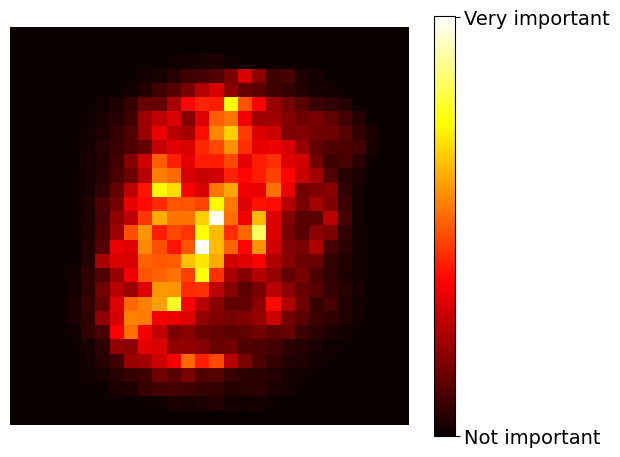

In [25]:
from sklearn.datasets import fetch_openml

X_mnist, y_mnist = fetch_openml('mnist_784', return_X_y=True, as_frame=False)

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)
rnd_clf.fit(X_mnist, y_mnist)

# This code is for generating the plot, a heatmap
heatmap_image = rnd_clf.feature_importances_.reshape(28, 28)
plt.imshow(heatmap_image, cmap="hot")
cbar = plt.colorbar(ticks=[rnd_clf.feature_importances_.min(),
                           rnd_clf.feature_importances_.max()])
cbar.ax.set_yticklabels(['Not important', 'Very important'], fontsize=14)
plt.axis("off")
save_fig("mnist_feature_importance_plot")
plt.show()